In order to enhance sampling in our S<sub>N</sub>2 example we're going to use metadynamics. The full details of the metadynamics setup can be found in the file <code>plumed.inp</code> in this directory. But basically we're going to build a bias potential $V(d_1,d_2)$ that will encourage the system to escape its initial metastable state and explore new states.

The bias potential is time-dependent because small Gaussian hills are added every 100 fs. However, because we use the well-tempered variant of metadynamics, the bias will asymptotically converge because the height of new Gaussians is decreased over time. Once the bias is converged, the system will effectively sample the histogram $H(d_1,d_2) = [P(d_1,d_2)]^{1/\gamma}$. That is, the *bias factor* $\gamma$ controls the degree to which the biased probability distribution is flattened. We have set $\gamma = 10$, which means that free energy barriers will be reduced to 10% of their original height (once the bias has converged). Let's see if that's enough:

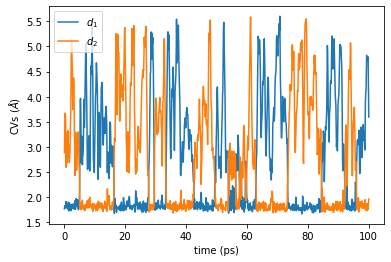

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

time = np.loadtxt('colvar', skiprows=1, usecols=0)
d1 = np.loadtxt('colvar', skiprows=1, usecols=1)
d2 = np.loadtxt('colvar', skiprows=1, usecols=2)
plt.plot(time,d1,label = "$d_1$")
plt.plot(time,d2,label = "$d_2$")
plt.xlabel("time (ps)")
plt.ylabel("CVs ($\AA$)")
plt.legend()
plt.show()

Some reactions happened! You can see that the growing bias is responsible for this:

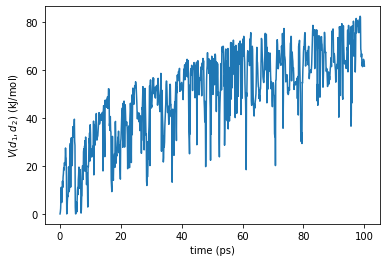

In [2]:
bias = np.loadtxt('colvar', skiprows=1, usecols=4)
plt.plot(time,bias)
plt.xlabel("time (ps)")
plt.ylabel("$V(d_1,d_2)$ (kJ/mol)")
plt.show()

Let's take a look at the histogram:

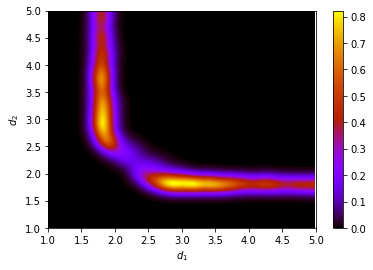

In [3]:
H=np.loadtxt("histo",usecols=[0,1,2],skiprows=10,unpack=True)
d1=d2=np.arange(1,5.01,0.01)
z=griddata((H[0],H[1]),H[2],(d1[None,:], d2[:,None]), method='cubic')
plt.imshow(z,origin="lower",aspect="auto",cmap="gnuplot",extent=[1,5,1,5])
plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.colorbar()
plt.show()

Two observations:
1. We now see two metastable basins, i.e., peaks in the probability distributions.
2. The two peaks themselves are much broader compared to the unbiased case. The "mild" bias potential (due to small $\gamma$) however ensures that only the path of least resistance between the two basins is taken, and no high-energy unphysical states (say, $(d_1,d_2) = (4,4)$) are sampled.

The flatted histogram $H(d_1,d_2)$ shows that sampling is good. However, it is not the actual probability distribution $P(d_1,d_2)$. Asymptotically, $P = H^\gamma$, but I doubt we have reached that regime already. A solution that converges more quickly, is *reweighting*. During the simulation, we construct $P$ again as a histogram, but we assign a variable weight to each sampled point. This weight is a function of the value of the bias potential. Because the bias potential is time-dependent, whereas the final probability distribution ought to be time-independent, metadynamics reweighting schemes are quite tricky. Here, we'll use the [scheme of Tiwary & Parrinello](dx.doi.org/10.1021/jp504920s), but note that competing approaches exist! As you'll see below, reweighting allows us to construct a probability distribution (or FES) along any set of CVs. This way the CVs for biasing can be decoupled from subsequent analysis.

*Nota bene:* If a bias $V(s)$ is time-independent, the relation with $P(s)$ is much more straightforward, because it is simply $P(s) = H(s) e^{\beta V(s)}$. If you wish to study the probability density of any other CV, though, you'll still have to reweight, but this will still be simpler than reweighting a dynamic bias.

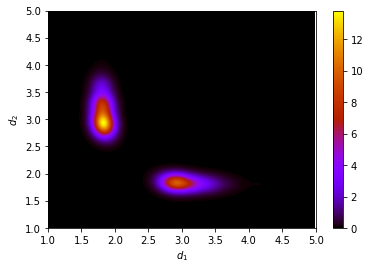

In [4]:
H=np.loadtxt("histo_reweight",usecols=[0,1,2],skiprows=10,unpack=True)
d1=d2=np.arange(1,5.01,0.01)
z=griddata((H[0],H[1]),H[2],(d1[None,:], d2[:,None]), method='cubic')
plt.imshow(z,origin="lower",aspect="auto",cmap="gnuplot",extent=[1,5,1,5])
plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.colorbar()
plt.show()

As expected, the individual basins now look again like the unbiased simulations (much sharper peaks). The difference is of course that we now actually see both relevant states. Now we'll plot the free energy surface $F = -\beta^{-1} \ln P$.

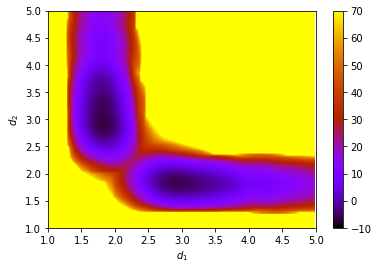

In [5]:
F=np.loadtxt("fes",usecols=[0,1,2],skiprows=10,unpack=True)
F[F == np.inf] = 70
d1=d2=np.arange(1,5.01,0.01)
z=griddata((F[0],F[1]),F[2],(d1[None,:], d2[:,None]), method='cubic')
plt.imshow(z,origin="lower",aspect="auto",cmap="gnuplot",vmin=-10,vmax=70,extent=[1,5,1,5])
plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.colorbar()
plt.show()

While colorful high-dimensional plots look cool, it's easier if we could go to lower-dimensional functions for analysis. Fortunately, our example process is so simple that we can intuitively come up with one-dimensional representation of the reaction coordinate. That is, we can use $\chi = (d_1 - d_2)/\sqrt{2}$ (normalized). This simple CV seems to be able to distinguish between states rather well:

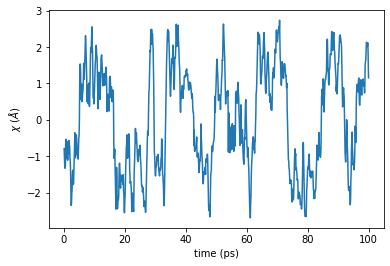

In [6]:
cv = np.loadtxt('colvar', skiprows=1, usecols=3)
plt.plot(time,cv)
plt.xlabel("time (ps)")
plt.ylabel("$\chi$ ($\AA$)")
plt.show()

And, given the existing trajectory (and associated weights), we can just as well project a distribution $P(\chi)$ on the CV $\chi$, even though the bias is a function of $(d_1,d_2)$:

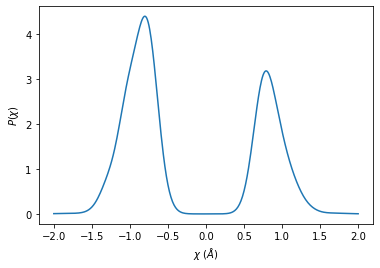

In [7]:
cv = np.loadtxt('histo1d', skiprows=1, usecols=0)
P = np.loadtxt('histo1d', skiprows=1, usecols=1)
plt.plot(cv,P)
plt.xlabel("$\chi$ ($\AA$)")
plt.ylabel("$P(\chi)$")
plt.show()

This histogram more clearly illustrates that state-to-state transitions are very difficult because they have to cross the low-probability region around $\chi = 0$ which is, well, not very probable. We can also plot the FES $F(\chi)$, where this crossing problem is visible in the perhaps more familiar form of a free energy barrier.

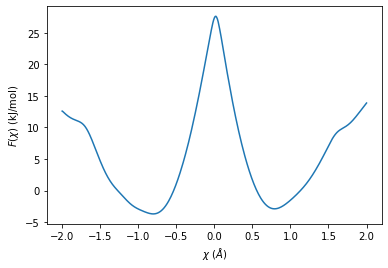

In [8]:
F = np.loadtxt('fes1d', skiprows=1, usecols=1)
plt.plot(cv,F)
plt.xlabel("$\chi$ ($\AA$)")
plt.ylabel("$F(\chi)$ (kJ/mol)")
plt.show()

Of the plotted quantities, a one-dimensional FES $F(\chi)$ is probably the easiest to interpret (from a chemical POV) and handle. So we can proceed to calculate useful quantities. A free energy difference $\Delta F$ between two states $A$ and $B$ is defined as:
$$\Delta F_{A \rightarrow B} = - \frac{1}{\beta} \ln \frac{Z_B}{Z_A}$$
in which $Z$ is a partition function of a state, which reads for state $A$
$$Z_A = \frac{\int_A \mathrm{d}\chi e^{-\beta F(\chi)}}{\int \mathrm{d}\chi \, e^{-\beta F(\chi)}}$$
so that we have
$$\Delta F_{A \rightarrow B} = - \frac{1}{\beta} \ln \frac{\int_B \mathrm{d}\chi \, e^{-\beta F(\chi)}}{\int_A \mathrm{d}\chi \, e^{-\beta F(\chi)}}$$
This yields:

In [9]:
kT = 2.494339
dx = 0.01 # integration step size
ZA = dx*np.sum(np.exp(-F[0:200]/kT))
ZB = dx*np.sum(np.exp(-F[200:400]/kT))
DeltaF = -kT*np.log(ZB/ZA)
print("Free energy difference: ", DeltaF, "kJ/mol")

Free energy difference:  1.0980657380021221 kJ/mol


We can also calculate the barrier of the $A \rightarrow B$ process (from low to high $\chi$). As I'll discuss later on, we want a defintion of the barrier $\Delta^\ddagger F$ that is compatible with the Eyring expression for the reaction rate:
$$k = (h \beta)^{-1} e^{-\beta \Delta^\ddagger F}$$
For this, we must compute the barrier as
$$\Delta^\ddagger F = F(\chi^*) + \frac{1}{\beta} \ln \frac{\langle |\nabla \chi| \rangle^{-1}_{\chi = \chi^*}}{h} \sqrt{\frac{2 \pi m}{\beta}} + \ln \int_A \mathrm{d}\chi \, e^{-\beta F(\chi)}$$
The norm gradient of the CV $\chi$ w/r/t all atomic coordinates is fairly simple in this case= $|\nabla \chi| = \sqrt{2}$.

In [10]:
h = 6.626e-34 * 6.022e23 / 1000 # Planck constant in kJ/mol
m = 0.012 # mass of carbon
grad = np.sqrt(2)*1e10 # A^-1 -> m^1
FA = -kT*np.log(ZA)
FTS = F[200]+kT*np.log(np.sqrt(2*np.pi*m*kT)/(grad*h))
barF = FTS - FA
rate = kT*np.exp(-barF/kT)/h
print("Free energy barrier ", barF, "kJ/mol")
print("Rate: ", rate, " s^(-1), corresponding to an average reaction time of ", 1e9/rate, " ns")

Free energy barrier  40.297775149924774 kJ/mol
Rate:  602053.3375806822  s^(-1), corresponding to an average reaction time of  1660.9824040149736  ns


Given that thermal energy at 300 K is about $k_B T = \beta^{-1} \approx 2.5$ kJ/mol, we can see that this barrier is indeed very difficult to overcome. Similarly, the low rate and high average reaction time put the process well beyond the 100 ps time scale of the simulation. This is why enhanced sampling methods are so useful.

**Further questions & exercises:**
1. Is this simulation fully converged? What would you consider acceptable? (Hint: look at the free energy difference & 1D histogram)
2. How can we distinguish systematic errors from random errors?
3. Does a high-quality estimate of $\Delta F$ also imply an accurate $\Delta^\ddagger F$ and well-sampled transition state?
4. If you can, perform additional simulations over longer time scales, and monitor convergence.
5. Suppose you bias not $(d_1,d_2)$, but only $\chi$: How would this affect performance?